In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.standardize import standardize_smiles
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from minedatabase.pickaxe import Pickaxe
from DORA_XGB import DORA_XGB
from tqdm import tqdm

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [26]:
expansion_name = "test" # "2_steps_ccm_aa_aplusb_True"
cpd_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_compound_metrics.parquet")
# cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head()

,smiles,fan_out,gen,id,expansion
0,O=C(O)CCC(=O)O,8,0,C4fe83a533b208e245e45b74e0967d7b8e9aad361,1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...
1,O=C(O)C=CC(=O)O,8,0,Cd2c8451fbe5563b9a086b59c26af17772205613a,1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...
2,O=C(O)CC(O)C(=O)O,9,0,Cc522b49cc542f782eb7779a6c90ac1a255334bfa,1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...
3,O=C(O)CC(=O)C(=O)O,16,0,C086e98dbf2ac460c91ac1a991badef07eb497a72,1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...
4,O=C(O)CCC(=O)C(=O)O,12,0,Ce264bf1bbd482e436995855afdf2170ce7229f1d,1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...


In [24]:
rxn_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_reaction_metrics.parquet")
# rxn_df = rxn_df.groupby("expansion").agg({"dxgb_label": "mean"}).reset_index()
rxn_df.head()

id  \
0  R3b25a7e0bed159020e2a34dc51c3cf7529c6ec4038177...   
1  Rdda1a22bada4082a3d67c1cd21dc3a233ae59012560a3...   
2  R1e20ec83eb90085c3eb8a894709c0d9a7fec3ffcafa57...   
3  Rd09eb66e0f70c16c4039f1c963e3916e3bdc2b673aac4...   
4  Rc60a924377a6511fa13131a5268d14f3e633cf1862c4a...   

                                              smarts  \
0  O=C(O)CCC(=O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP...   
1  NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...   
2  NC(N)=NCCCC(N)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(...   
3  O=C(O)CCC(=O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OS...   
4  NC(CS)C(=O)O.O=C(O)CCC(=O)O>>NC(COC(=O)CCC(=O)...   

                                           am_smarts  dxgb_label  max_rxn_sim  \
0  [O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...           0     0.946580   
1  [NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([CH:7]2...           0     1.000000   
2  [NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...           1     0.942430   
3  [O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...           0     0.915702   
4  [NH2:1][CH:2]([CH2:3][SH:4])[C:5](=[O:6])[OH:7...           1     1.000000   

                                    nearest_analogue nearest_analogue_id  \
0  CCCC(=O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(...                4571   
1  NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...               10119   
2  N=C(N)NCCCC(N)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(...               10174   
3  *O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OS(=O)(=O)O)C(...                6442   
4  NC(CS)C(=O)O.O=C(O)CCC(=O)O>>NC(COC(=O)CCC(=O)...               11066   

                         rules  \
0                     [8661_1]   
1                       [87_0]   
2  [136_0_0_0, 136_0_0, 136_0]   
3                     [7793_0]   
4  [711_0_0, 711_0, 711_0_0_0]   

                                           expansion  
0  1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...  
1  1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...  
2  1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...  
3  1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...  
4  1_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...

(array([  1.,   0.,   0.,   0.,   1.,   0.,   2.,   6.,  58., 170.]),
 array([0.05882353, 0.15294118, 0.24705882, 0.34117647, 0.43529412,
        0.52941176, 0.62352941, 0.71764706, 0.81176471, 0.90588235,
        1.        ]),
 <BarContainer object of 10 artists>)

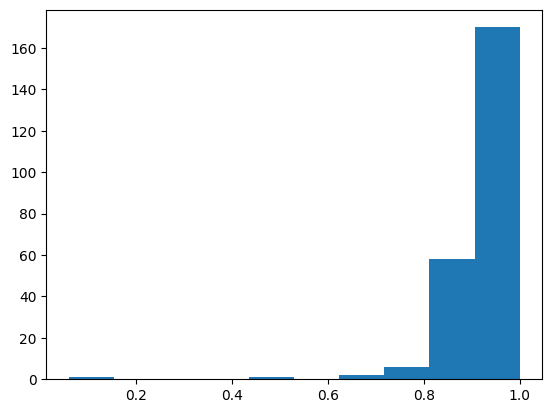

In [25]:
plt.hist(rxn_df["max_rxn_sim"])

In [166]:
expansion_name = "two_least_permissive"
cpd_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_compound_metrics.parquet")
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]})
cpd_df.head()

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_imt_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:33] WARNING: not removing hydrogen atom without neighbors


Loaded 49241 compounds
Loaded 80395 reactions
Loaded 1852 operators
Loaded 64 coreactants
Loaded 2 generation
Took 2.1428401470184326
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:34] WARNING: not removing hydrogen atom without neighbors


Loaded 13600 compounds
Loaded 22671 reactions
Loaded 3746 operators
Loaded 67 coreactants
Loaded 2 generation
Took 0.7338380813598633
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:37] WARNING: not removing hydrogen atom without neighbors


Loaded 6259 compounds
Loaded 9809 reactions
Loaded 7335 operators
Loaded 71 coreactants
Loaded 2 generation
Took 2.542391300201416
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:40] WARNING: not removing hydrogen atom without neighbors


Loaded 8066 compounds
Loaded 13245 reactions
Loaded 6236 operators
Loaded 70 coreactants
Loaded 2 generation
Took 1.9142911434173584
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:43] WARNING: not removing hydrogen atom without neighbors


Loaded 9248 compounds
Loaded 15729 reactions
Loaded 5473 operators
Loaded 69 coreactants
Loaded 2 generation
Took 1.9191861152648926
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:44] WARNING: not removing hydrogen atom without neighbors
[12:48:44] WARNING: not removing hydrogen atom without neighbors


Loaded 20312 compounds
Loaded 32908 reactions
Loaded 2207 operators
Loaded 65 coreactants
Loaded 2 generation
Took 0.7548308372497559
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 6629 compounds
Loaded 11711 reactions
Loaded 757 operators
Loaded 66 coreactants
Loaded 2 generation
Took 0.20459961891174316
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:56] WARNING: not removing hydrogen atom without neighbors


Loaded 372224 compounds
Loaded 702208 reactions
Loaded 1453 operators
Loaded 58 coreactants
Loaded 2 generation
Took 11.377429485321045
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:57] WARNING: not removing hydrogen atom without neighbors


Loaded 5756 compounds
Loaded 9210 reactions
Loaded 3853 operators
Loaded 71 coreactants
Loaded 2 generation
Took 0.6674985885620117
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk pickled data.


[12:48:58] WARNING: not removing hydrogen atom without neighbors


Loaded 2273 compounds
Loaded 3477 reactions
Loaded 5266 operators
Loaded 72 coreactants
Loaded 2 generation
Took 1.3737273216247559
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk pickled data.


[12:49:01] WARNING: not removing hydrogen atom without neighbors


Loaded 1373 compounds
Loaded 1881 reactions
Loaded 6351 operators
Loaded 74 coreactants
Loaded 2 generation
Took 1.8340682983398438
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 1176 compounds
Loaded 1597 reactions
Loaded 7204 operators
Loaded 74 coreactants
Loaded 2 generation
Took 2.596092700958252


[12:49:04] WARNING: not removing hydrogen atom without neighbors


,expansion,n_rxns,n_cpds
0,2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...,80395,49241
1,2_steps_ccm_aa_rules_mechinferred_dt_15_rules_...,22671,13600
2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk,0,13.758621,6.711691


In [27]:
rxn_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_reaction_metrics.parquet")
rxn_df.head(12)

,smarts,dxgb_label,id,rules,expansion
0,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,1,Ra5466f30b2eff8d962354506782f3c774e2dbccfeabcc...,[813_1],2_steps_ccm_aa_rules_mechinformed_rules_w_core...
1,O=C(O)CCC(=O)O.CC(N)C(=O)O>>CC(NC(=O)CCC(=O)O)...,1,R1a6f3d7e229c81ffd5e77b63a4191e793232130cbc0e0...,"[8_0, 8_0_0, 8_0_0_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
2,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,1,Ra9e6706c0b8df38fa1056bb4ad1ac443a60e95f3e02f1...,[558_1],2_steps_ccm_aa_rules_mechinformed_rules_w_core...
3,O=C(O)CCC(=O)O.O=C(O)CCC(=O)O>>O.O=C(O)CCC(=O)...,0,Rec6d7525917f77e5f6c7a5942c1b7197b67be650c7476...,"[167_0, 167_0_1, 167_0_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
4,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,0,R3b25a7e0bed159020e2a34dc51c3cf7529c6ec4038177...,"[382_1, 333_1, 631_1]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
5,O=C(O)CCC(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=...,0,Rdda1a22bada4082a3d67c1cd21dc3a233ae59012560a3...,[177_0],2_steps_ccm_aa_rules_mechinformed_rules_w_core...
6,O=C(O)CC(O)C(=O)O.O=C(O)CCC(=O)O>>O=C(O)CCC(=O...,0,R6dc78a68eef458cf00438747bfce2c91d2d4bd21a1da9...,"[703_0, 703_0_0_0, 703_0_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
7,O=C(O)CC(O)C(=O)O.O=C(O)CCC(=O)O>>O=C(O)CCC(=O...,0,Rf38295782a37516f50c0a439e1529a53e2a9c6a384178...,"[703_0, 703_0_0_0, 703_0_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
8,O=C(O)CCC(=O)O.NC(CS)C(=O)O>>NC(CSC(=O)CCC(=O)...,1,Rd5f9bc7f1dff6d19cd8c03152d4455d66d5bedf22be69...,"[216_0_0, 216_0_0_0, 216_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
9,O=C(O)CCC(=O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OS...,0,Rd09eb66e0f70c16c4039f1c963e3916e3bdc2b673aac4...,[891_0],2_steps_ccm_aa_rules_mechinformed_rules_w_core...


Spot check

In [ ]:
kr_feas_df = pd.read_parquet(Path(cfg.processed_data) / "sprhea_v3_dxgb_ac.parquet")

In [114]:
mechinformed = rxn_df.loc[rxn_df.expansion == '2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk']

In [ ]:
def show_mechinformed_reaction(idx):
    row = mechinformed.iloc[idx]
    print(f"dxgb_label: {row['dxgb_label']}")
    print(f"rule: {row["rules"]}")
    display(SVG(draw_reaction(row['smarts'])))

interact(show_mechinformed_reaction, idx=widgets.IntSlider(min=0, max=len(mechinformed)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=11708), Output()), _dom_classes=('widget-inter…

<function __main__.show_mechinformed_reaction(idx)>

In [116]:
rxn_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_reaction_metrics.parquet")
rxn_df = rxn_df.groupby("expansion").agg({"dxgb_label": "mean"})
rxn_df.head()

dxgb_label
expansion                                                     
2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_...    0.544323
2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_...    0.515559
2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreacta...    0.648188
2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreacta...    0.658920